# Messtechnik HS2021 - Tutorial 7

## Aufgabe: Datenverarbeitung für höhere Auflösung
--------------------
Analysieren Sie den simulierten *free induction decay* ``FID.mat`` (das Format ``.mat`` entspricht eine MATLAB formatierte Datei), welcher mit $e^{-\sigma^2t^2/2}$ und dem Zerfallsparameter $\sigma = $ 1.6 MHz abklingt. Ein solcher Zerfall kann zum Beispiel dann beobachtet werden, wenn die Resonanzfrequenzen Gauss-verteilt sind. Das Signal enthält zusätzlich Rauschen, das mit einem Pseudozufallszahlengenerator (*pseudo-random number generator*) erzeugt wurde.

-----------------
__(a)__ Versuchen Sie mit Hilfe der *Self-deconvolution*, *Zero-filling* und *Apodization* die spektrale Auflösung zu verbessern und die ursprüngliche unverbreitete Linien zurückzuerhalten. Überlagern Sie den originalen FID mit ihrer Apodisationsvariante, sowohl im Zeit- wie auch im Frequenzraum. 

* Wie viele Linien erkennen Sie im Spektrum? 
* Was sind die Amplitudenverhältnisse dieser Linien? 
* Geben Sie für jede Window-Funktion, welche Sie zur Apodisation verwenden, den Effekt auf die spektrale Linienbreite an (Verbreiterung/Verschmälerung). 

__(i)__ Fourier Transform + Zero-filling

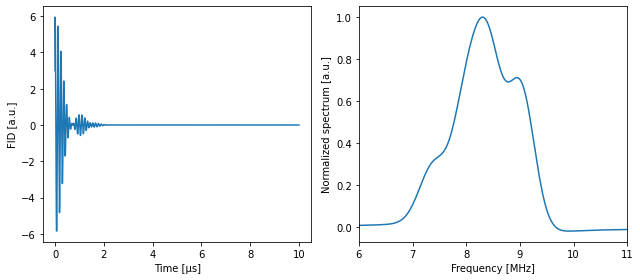

In [139]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.fft import fft,fftshift
from scipy.io import loadmat 

# Load the MATLAB-formatted file
data = loadmat('FID.mat',squeeze_me=True)
t = data['t'] # microseconds
fid = data['I1'] # arb. units


# Construct frequency axis: for even Npts, (fs/Npts) increment in [-fs/2,fs/2] 
zerofilling = 3*len(fid)
Nfreq = len(fid) + zerofilling # Points in frequency-domain = length of FID + zero-filling of length of FID
dt = t[1] - t[0] # FID sampling steps
nyq_freq = 1/(dt*2) # MHz
freq = np.linspace(-nyq_freq,nyq_freq,Nfreq) # MHz

# Get the spectrum, weight first point by 0.5
fidw = fid 
fidw[0] /= 2

# Get the spectrum
spc = fftshift(fft(fidw,Nfreq))
spc /= max(spc) # normalize to maximum

# Plot time-domain FID
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.plot(t,fid)
plt.ylabel('FID [a.u.]')
plt.xlabel('Time [µs]')

# Plot frequency-domain spectrum
plt.subplot(1,2,2)
plt.plot(freq,spc.real)
plt.ylabel('Normalized spectrum [a.u.]')
plt.xlabel('Frequency [MHz]')
# Plot only a region of positive frequencies: since the FID has only a real component, 
# the positive and negative frequencies are indistinguishable
plt.xlim([6,11]) 

plt.tight_layout()
plt.show()

__(ii)__ Self-deconvolution

Wenn man die Gauss'sche Envelope des Signals kompensiert mit $e^{\sigma_\text{apo}^2t^2/2}$ bekommt man ein Spektrum mit schmaleren Linien. Das führt aber zu einer Explosion des Rauschen bei spätere Zeiten. 

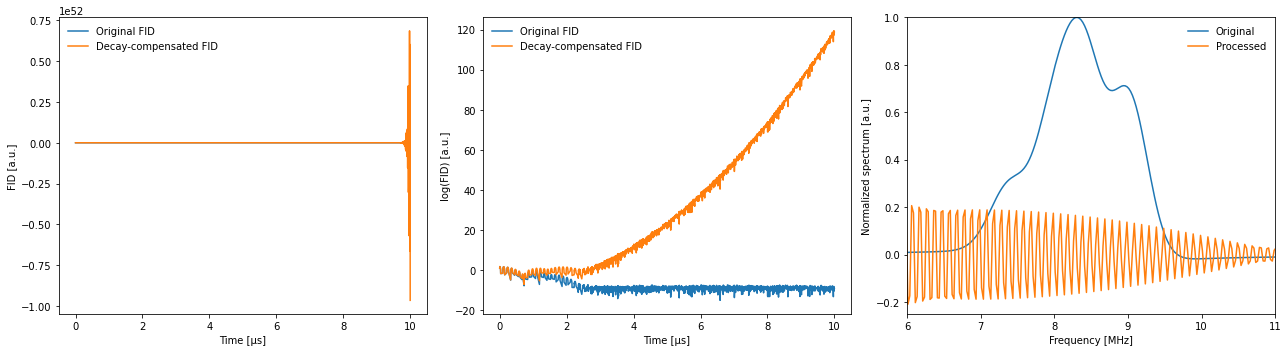

In [140]:
sigma = 1.6 # MHz, the decay constant as given in the tasksheet
apo_sigma = sigma*1.0 # the rise constant of the apodization window

# Envelope function of the FID Gaussian decay
envelope_decay = np.exp(apo_sigma**2*t**2/2)

# Compensation of the FID Gaussian decay
fid_comp = fid*envelope_decay

# Get the spectrum
spc_comp = fftshift(fft(fid_comp,Nfreq))
spc_comp /= max(spc_comp) # normalize to maximum

plt.figure(figsize=[18,5])
plt.subplot(131)
plt.plot(t,fid,t,fid_comp)
plt.xlabel('Time [µs]')
plt.ylabel('FID [a.u.]')
plt.legend(['Original FID','Decay-compensated FID'],frameon=False)

plt.subplot(132)
plt.plot(t[fid>0],np.log(fid[fid>0]),t[fid_comp>0],np.log(fid_comp[fid_comp>0]))
plt.xlabel('Time [µs]')
plt.ylabel('log(FID) [a.u.]')
plt.legend(['Original FID','Decay-compensated FID'],frameon=False)

plt.subplot(133)
plt.plot(freq,spc.real,freq,spc_comp.real)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Normalized spectrum [a.u.]')
plt.legend(['Original','Processed'],loc='upper right',frameon=False)
plt.xlim([6,11]) 
plt.ylim([-0.25,1]) 

plt.tight_layout()
plt.show()

__(iii)__ Truncation 

Bei der Korrektur mit $e^{\sigma_\text{apo}^2t^2/2}$ explodiert gegen Ende des Zeitintervalls das Rauschen. Um das S/N im Frequenzbereich zu minimieren, muss man das Signal im Zeitbereich ab einem bestimmten Zeitpunkt abschneiden. 

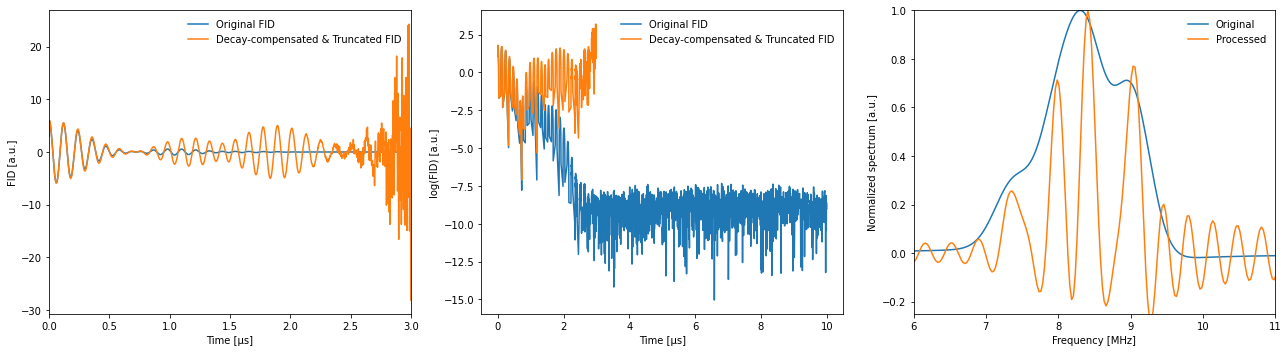

In [141]:
# Signal truncation
cutoff = 3 # We choose 3 us as the time where the signal has decayed
fid_cut = fid_comp[t<=cutoff] # Cut the FID vector at t_cut
t_cut = t[t<=cutoff]

# Get the spectrum
spc_cut = fftshift(fft(fid_cut,Nfreq))
spc_cut /= max(spc_cut) # normalize to maximum
 
plt.figure(figsize=[18,5])
plt.subplot(131)
plt.plot(t,fid,t_cut,fid_cut)
plt.xlabel('Time [µs]')
plt.ylabel('FID [a.u.]')
plt.legend(['Original FID','Decay-compensated & Truncated FID'],frameon=False)
plt.xlim([0,3])

plt.subplot(132)
plt.plot(t[fid>0],np.log(fid[fid>0]),t_cut[fid_cut>0],np.log(fid_cut[fid_cut>0]))
plt.xlabel('Time [µs]')
plt.ylabel('log(FID) [a.u.]')
plt.legend(['Original FID','Decay-compensated & Truncated FID'],frameon=False)

plt.subplot(133)
plt.plot(freq,spc.real,freq,spc_cut.real)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Normalized spectrum [a.u.]')
plt.legend(['Original','Processed'],loc='upper right',frameon=False)
plt.xlim([6,11]) 
plt.ylim([-0.25,1]) 

plt.tight_layout()
plt.show()

__(iv)__  Apodisierung 

Um Abschneide-Effekte zu verhindern, wurde ausserdem ein Hamming-Window verwendet (Gl. (8.29) im Skript).

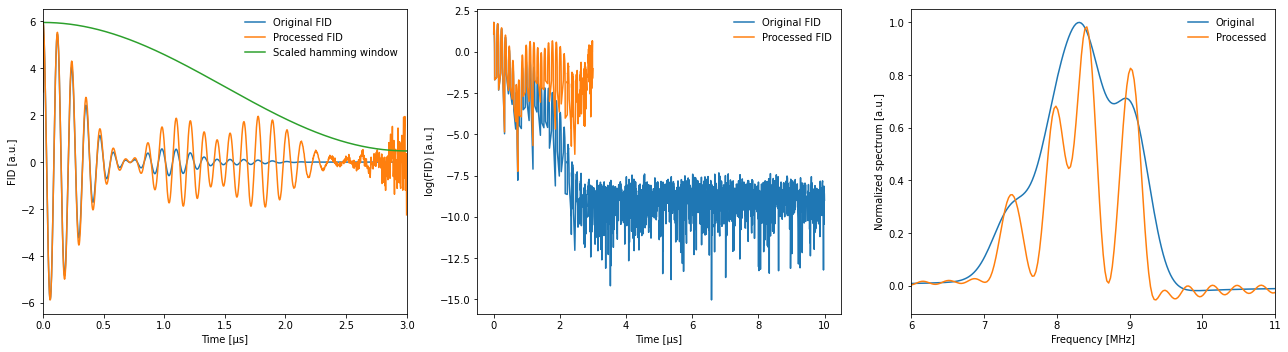

In [142]:
# Signal apodization
n = np.arange(len(t_cut))
hamming_win = 0.54 + 0.46*np.cos(np.pi*n/max(n))

fid_apo = fid_cut*hamming_win

# Get the spectrum
spc_apo = fftshift(fft(fid_apo,Nfreq))
spc_apo /= max(spc_apo) # normalize to maximum
 
plt.figure(figsize=[18,5])
plt.subplot(131)
plt.plot(t,fid,t_cut,fid_apo,t_cut,hamming_win*max(fid_apo))
plt.xlabel('Time [µs]')
plt.ylabel('FID [a.u.]')
plt.legend(['Original FID','Processed FID','Scaled hamming window'],frameon=False)
plt.xlim([0,3])

plt.subplot(132)
plt.plot(t[fid>0],np.log(fid[fid>0]),t_cut[fid_apo>0],np.log(fid_apo[fid_apo>0]))
plt.xlabel('Time [µs]')
plt.ylabel('log(FID) [a.u.]')
plt.legend(['Original FID','Processed FID'],frameon=False)

plt.subplot(133)
plt.plot(freq,spc.real,freq,spc_apo.real)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Normalized spectrum [a.u.]')
plt.legend(['Original','Processed'],loc='upper right',frameon=False)
plt.xlim([6,11]) 

plt.tight_layout()
plt.show()

Beobachtungen: 
* Es sind 4 Spektrallinien zu erkennen. 
* Die Amplitudenverhältnisse kann man aus der Abbildung direkt ablesen: approx. 0.35/0.6/1.0/0.8
* Da die Signalenvelope mit $e^{-\sigma^2t^2/2}$ exakt kompensiert wird, haben die Linien im apodisierten Spektrum \emph{keine} Gauss'sche Verbreiterung mehr. 
Da der FID jedoch mit einem Hamming-Window überlagert ist, werden die Linien nun wiederum verbreitert. 

-----------------
__(b)__ Normalerweise ist der Zerfallsparameter $\sigma$ nicht genau bekannt. Wie verändert sich das Spektrum, wenn Sie anstelle von $\sigma = $ 1.6 MHz von einem grösseren oder einem kleineren $\sigma$ ausgehen?

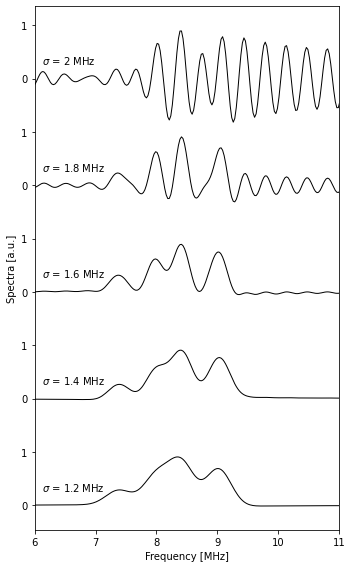

In [163]:
#----------------------------------------------------------------------------------------
def process_decay_compensation(sigma, cutoff=3):
    """
    This function performs the same analysis as in in the previous
    section with a given decay parameter sigma
    """
    # Load the MATLAB-formatted file
    data = loadmat('FID.mat',squeeze_me=True)
    t = data['t'] # microseconds
    fid = data['I1'] # arb. units

    # Construct frequency axis: for even Npts, (fs/Npts) increment in [-fs/2,fs/2] 
    zerofilling = 3*len(fid)
    Nfreq = len(fid) + zerofilling # Points in frequency-domain = length of FID + zero-filling of length of FID
    dt = t[1] - t[0] # FID sampling steps
    nyq_freq = 1/(dt*2) # MHz
    freq = np.linspace(-nyq_freq,nyq_freq,Nfreq) # MHz

    # Get the spectrum, weight first point by 0.5
    fidw = fid
    fidw[0] /= 2

    # Envelope function of the FID Gaussian decay
    apo_sigma = sigma*1.0 # the rise constant of the apodization window
    envelope_decay = np.exp(apo_sigma**2*t**2/2)

    # Compensation of the FID Gaussian decay
    fid_comp = fid*envelope_decay

    # Signal truncation
    fid_cut = fid_comp[t<=cutoff] # Cut the FID vector at t_cut
    t_cut = t[t<=cutoff]
    
    # Signal apodization
    n = np.arange(len(t_cut))
    hamming_win = 0.54 + 0.46*np.cos(np.pi*n/max(n))

    fid_apo = fid_cut*hamming_win

    # Get the spectrum
    spc_apo = fftshift(fft(fid_apo,Nfreq))
    spc_apo /= max(spc_apo) # normalize to maximum

    return freq,spc_apo
#----------------------------------------------------------------------------------------


# List of sigma values to evaluate
sigmas = [1.2, 1.4, 1.6, 1.8, 2] # MHz

plt.figure(figsize=[5,8])
for n,sigma in enumerate(sigmas):
    # Process the FID data
    freq,spec = process_decay_compensation(sigma) 
    # Plot the processed spectrum
    plt.plot(freq,2.2*n + spec.real,color='k', linewidth=1) 
    # Add text next to spectrum
    plt.annotate(f'$\sigma$ = {sigma} MHz', xy=(6,0.5+2.2*n), xytext=(1.02*6, 0.3+2.2*n), color='k')
    plt.yticks(ticks=1.1*np.arange(2*len(sigmas)),labels=[0,1,0,1,0,1,0,1,0,1])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Spectra [a.u.]')
plt.xlim([6,11]) 

plt.tight_layout()
plt.show() 


Bei unbekanntem $\sigma$ ist die Wahl einer geeigneten Zerfallskonstante $\sigma_\text{apo}$ zur Apodisation kritisch. Zum einen kann die Zerfallskonstante unterschätzt werden. In diesem Falle wird die Gauss'sche Envelope nicht vollständig kompensiert. Demnach ist das apodisierte Zeitsignal $e^{-(\sigma^2-\sigma_\text{apo}^2)t^2/2}$ eine abfallende Funktion. Die spektralen Linien werden also breiter wenn $\sigma_\text{apo} < \sigma$ als wenn $\sigma_\text{apo} = \sigma$.

Es kann ebenfalls vorkommen, dass $\sigma$ überschätzt wird, also dass $\sigma_\text{apo} > \sigma$. In diesem Falle wird die Gauss'sche Envelope überkompensiert. Das apodisierte Zeitsignal $e^{-(\sigma^2-\sigma_\text{apo}^2)t^2/2}$ ist demnach eine ansteigende Funktion. Im Absorptionsspektrum können daher *gestauchte* Linien auftreten, die zur Seite hin zu negativen Werten ausschlagen. Wenn Linien mit unterschiedlichen Zerfallseigenschaften überlappen und voneinander getrennt werden müssen, gilt es immer einen geeigneten Kompromiss zu finden.
